## Quasi-Minimal Residual Method
### Eric Valentino and Kiran Shila


In [66]:
# Doing Imports
using BenchmarkTools
using Plots
using LinearAlgebra
using SparseArrays
using Statistics

In [48]:
@enum ConvergenceReason MaximumIterations = 1  ConvergenceSatisfied = 2  MinimumEncountered = 3

function qmr(A, b; x0=zeros(length(b)) ,rtol= 1e-6, maxit=min(length(b),20) , M1 = I, M2 = I)
#   if true
    # MAKING FUNCTION FOR RIGHT PRECONDITIONER
    M1m1x = x-> M1 \x
    M1tm1x = x-> M1' \x

    # MAKING FUNCTION FOR LEFT PRECONDITIONER
    M2m1x = x-> M2 \x
    M2tm1x = x-> M2' \x

    # MAKING FUNCTION FOR MULTIPLYING BY A
    Ax = x -> A*x
    Atx = x -> A'*x

    x = x0

    r = b - A*x

    bnorm = norm(b)
    res0 = norm(r)

    resvec = [res0]

    vt = r

    y = M1m1x(vt)

    rho0 = norm(y)
    wt = r

    z = M2tm1x(wt)

    xi1 = norm(z)
    gamma0 = 1
    eta0 = -1
    flag = MaximumIterations

    # declaring things so they don't go out of scope in for loop
    eps0 = 0
    v = nothing
    w = nothing
    p = nothing
    q = nothing
    p = nothing
    beta1 = nothing
    rho1 = nothing
    theta0 = nothing
    theta1 = nothing
    gamma1 = nothing
    eta1 = nothing
    d = nothing
    s = nothing
    res1 = nothing
    last_iter = nothing

    for iter=1:1:maxit
      ## If rho0 == 0 or xi1 == 0, method fails.
      v = vt / rho0
      y /= rho0
      w = wt / xi1
      z /= xi1

      delta1 = z' * y   # If delta1 == 0, method fails.

      yt = M2m1x(y)
      zt = M1tm1x(z)

      iter
      if (iter == 1)
        p = yt
        q = zt
      else# 2nd or higher
        p = yt - (xi1*delta1/eps0) * p
        q = zt - (rho0*delta1/eps0) * q
      end
      pt = Ax(p)

      eps0 = (q' * pt)[1]          # If eps0 == 0, method fails.
      beta1 = eps0 / delta1   # If beta1 == 0, method fails.
      vt = pt - beta1 * v

      y = M1m1x(vt)
      rho1 = norm(y)
      wt = Atx(q) - beta1 * w
      z = M2tm1x(wt)

      xi1 = norm(z)
      theta1 = rho1 / (gamma0 * abs(beta1))
      gamma1 = 1 / sqrt(1 + theta1^2)   # If gamma1 == 0, method fails.
      eta1 = -eta0 * rho0 * gamma1^2 / (beta1 * gamma0^2)

      if (iter == 1)
        d = eta1 * p
        s = eta1 * pt
      else
        d = eta1 * p + (theta0*gamma1)^2 * d
        s = eta1 * pt + (theta0 * gamma1)^2 * s
      end
      x += d
      r -= s

      res1 = norm(r) / bnorm
      # if (nargout > 4)
      # resvec(iter + 1, 1) = norm(r)
      push!(resvec,norm(r))
      # end

      if (res1 < rtol)
        # Solver Converged with tolerance
        flag = ConvergenceSatisfied
        last_iter = iter
        break
      elseif (res0 <= res1)
        # Local minimum found
        flag = MinimumEncountered
        last_iter = iter
        break
      end
      theta0 = theta1
      eta0 = eta1
      gamma0 = gamma1
      rho0 = rho1
    end #for

    relres = res1
    if (flag == MaximumIterations)
        
#         println("Terminated at iteration %i without converging to the\n
#                 tolerance %e as the iteration count exceeded the maximum\n
#                 allotted.
#                 Residual: %e\n",last_iter,rtol,res1 )
    elseif (flag == MinimumEncountered)
        
#         println("qmr stopped at iteration %i
#                 without converging to the desired tolerance %e\n
#                 because the method stagnated.\n
#                 The iterate returned has relative residual %e\n", last_iter,rtol,res1)
    else # satisfied residual
#         println("Converged at iteration %i
#                 to a solution with residual %e\n", last_iter,res1)
    end
  return x, flag, relres, last_iter, resvec
end




qmr (generic function with 1 method)

# Testing on a small matrix

In order to verify that the QMR iterative solver is indeed solving $ Ax = b $, we can compare it to Julia's built-in backslash method, which is comparable to the MATLAB backslash

In [24]:
A = [1 2 3; 4 5 6;7 8 0]; b = [1,2,3] # 0 at end so matrix is not singular
A

3×3 Array{Int64,2}:
 1  2  3
 4  5  6
 7  8  0

In [25]:
b

3-element Array{Int64,1}:
 1
 2
 3

# Julia's built-in direct solution to the problem of $ Ax = b $ in this context is as follows:

In [36]:
A\b

3-element Array{Float64,1}:
 -0.33333333333333326
  0.6666666666666666 
 -0.0                

# Our QMR implementation produces the same output within $\epsilon$

In [40]:
x = qmr(A,b)
x

iter = 1
iter = 2
iter = 3
Converged at iteration %i
                to a solution with residual %e
36.239609671474476e-15


([-0.333333, 0.666667, 1.01308e-15], ConvergenceSatisfied::ConvergenceReason = 2, 6.239609671474476e-15, 3, [3.74166, 1.28255, 0.249391, 2.33465e-14])

# Performance

QMR, although naively implemented by us, should outperform direct computation of an inverse. Solving of $Ax=b$ by taking the inverse should perform worse in time and memory when compared to our solver.

In order to demonstrate this, we will plot the time it takes for QMR and the inverse to solve increasingly large matrices.

# Calculating the time and memory needed for qmr

In [107]:
sizes = floor.(Int32,exp10.(range(log10(5),stop=log10(200),length=10)))

qmr_times = []
qmr_mems = []
for n in sizes
    a = sprand(n, n, .1)
    A = a' * a + 100 *I # making diagonal dominate
    b = sum(Array(A) , dims = 2)
    d = @benchmark qmr(A, vec(b),rtol=1e-4)
    push!(qmr_times,mean(d.times))
    push!(qmr_mems,mean(d.memory))
end 

In [108]:
inv_times = []
inv_mems = []
for n in sizes
    a = sprand(n, n, .1)
    A = a' * a + 100 *I # making diagonal dominate
    b = sum(Array(A) , dims = 2)
    d = @benchmark inv(Array(A))*b
    push!(inv_times,mean(d.times))
    push!(inv_mems,mean(d.memory))
end 

# Time Complexity: QMR v.s. Inverse

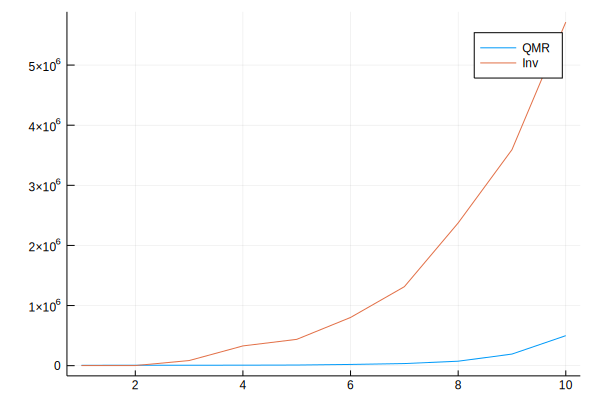

In [109]:
plot(qmr_times ,label="QMR")
plot!(inv_times ,label="Inv" )

# Memory Consumption: QMR v.s. Inverse

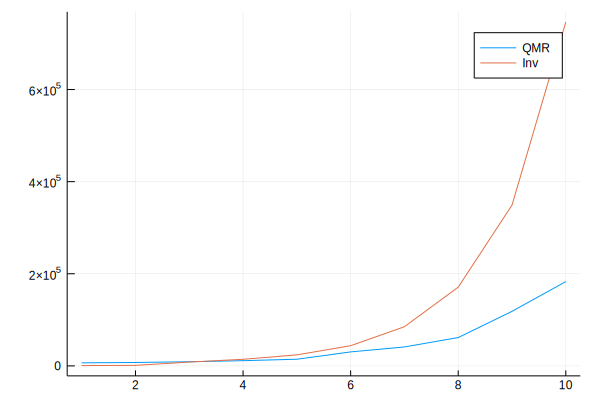

In [110]:
plot(qmr_mems ,label="QMR")
plot!(inv_mems ,label="Inv" )

In [ ]:


# test
n = 100
# @show A = spdiagm(-1=>-2*ones(n-2,1),0=>4*ones(n,1), 1=>-ones(n-2,1))
# b = sum(A, dims=2)
# @show size(b)

## Case 1
# n = 10
# A = spdiagm(-1=>ones(n-2),0=>4*ones(n),1=>ones(n-2))
# b = sum(A,dims= 2)

a = sprand(n, n, .1)
A = a' * a + 100 *I
b = sum(Array(A) , dims = 2)
x, flag, relres, iter, resvec = qmr(A, vec(b))
 # assert(x, ones (size (b)), 1e-7)
@show x
@show A\b

# Function from Kiran's Week 5
# I'd rather pass in numpoints as a tuple so I can support non-square problem spaces
function poisson_2d_dirichlet(source::Function,dirichlet::Function, L::Number,H::Number,numPoints::Tuple{Integer,Integer})
    # numPoints[1] is the "L" from my formulation
    Δx = L/numPoints[1] # Physical resolutions
    Δy = H/numPoints[2]

    # We are only solving the inner matrix, the outer edge is defined with the boundary condition
    problemSpace = (numPoints[1])*(numPoints[2])

    # Form the diagonals
    mainDiagonal = 0 => fill(-2,problemSpace)
    topDiagonal =  1 => fill(1,problemSpace-1)
    botDiagonal = -1 => fill(1,problemSpace-1)
    D_x = spdiagm(mainDiagonal,topDiagonal,botDiagonal)
    # Now place the zeros in the off-diagonals
    for i = numPoints[1]:numPoints[1]:problemSpace-1
        D_x[i,i+1] = 0
        D_x[i+1,i] = 0
    end
    # And fix the sparse matrix to clean the zeros
    dropzeros!(D_x)

    # Now to formulate D_y
    topDiagonal =  numPoints[1] => fill(1,problemSpace-(numPoints[2]))
    botDiagonal = -(numPoints[1]) => fill(1,problemSpace-(numPoints[2]))
    D_y = spdiagm(mainDiagonal,topDiagonal,botDiagonal)

    # Now make A
    A = (-(1/Δx^2).*D_x -(1/Δy^2).*D_y)

    # Now generate the source vector in 2D
    s = [source(x,y,numPoints[1],numPoints[2]) for x = 1:numPoints[1], y = 1:numPoints[2]]
    b = copy(s)

    # Apply the boundary conditions
    for j=1:numPoints[1]
        if j == 1
            # Top left
            b[1,j] = b[1,j] + dirichlet(2,1,numPoints[1],numPoints[2])/Δy^2 + dirichlet(1,2,numPoints[1],numPoints[2])/Δx^2
            # Bottom Left
            b[end,j] = b[end,j] + dirichlet(2,numPoints[2]+2,numPoints[1],numPoints[2])/Δy^2 + dirichlet(1,numPoints[2]+1,numPoints[1],numPoints[2])/Δx^2
        elseif j == numPoints[2]
            # Top Right
            b[1,j] = b[1,j] + dirichlet(numPoints[1]+1,1,numPoints[1],numPoints[2])/Δy^2 + dirichlet(numPoints[1]+2,2,numPoints[1],numPoints[2])/Δx^2
            # Bottom Right
            b[end,j] = b[end,j] + dirichlet(numPoints[1]+1,numPoints[2]+2,numPoints[1],numPoints[2])/Δy^2 + dirichlet(numPoints[1]+2,numPoints[2]+1,numPoints[1],numPoints[2])/Δx^2
        else
            # Top Edge
            b[1,j] = b[1,j] + dirichlet(j+1,1,numPoints[1],numPoints[2])/Δy^2

            # Bottom Edge
            b[end,j] = b[end,j] + dirichlet(j+1,numPoints[2]+2,numPoints[1],numPoints[2])/Δy^2
        end
    end

    # Now for left and right edge
    for i=2:numPoints[2]-1
        # Left Edge
        b[i,1] = b[i,1] + dirichlet(1,i+1,numPoints[1],numPoints[2])/Δx^2
        # Right Edge
        b[i,end] = b[i,end] + dirichlet(numPoints[1]+2,i+1,numPoints[1],numPoints[2])/Δx^2
    end

    # Reshape to 1D
    b = reshape(b,problemSpace)

    # Solve and benchmark
    # f,time,bytes = @timed A\b

    # Solve
    # return reshape(f,(numPoints[1],numPoints[2])) , s, time, bytes
    return A,b
end


# Zero Source
function zero_s(args...)
    return 0.
end

# Uniform Source
function uniform_s(args...)
    return 1.
end

# Linear Source
function linear_s(args...)
    return args[1]/args[3] # x/L
end

# Linear Source in x and y
function linear_xy_s(args...)
    return args[1]/args[3] + (2*args[2])/args[4]
end

# Non Linear
function nonlinear_s(args...)
    return 50*((args[1]/args[3])^2 + sin(10*args[2]/args[4]))
end

function non_homogeneous(args...)
    return 1.
end

L = 1; H = 1; x_size = 100; y_size = 100
A,b = poisson_2d_dirichlet(zero_s,homogeneous,L,H,(x_size,y_size))
p1 = heatmap(b,aspect_ratio=:equal,title="Result")
# p2 = heatmap(s,aspect_ratio=:equal,title="Source")
# plot(p1,p2,layout=2)
plot(p1)
